In [7]:
from src.sentimentanalysis_tf.Kaggle import Kaggle
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import keras as K
from keras._tf_keras.keras import Sequential
from keras._tf_keras.keras.layers import Embedding, LSTM, Dense, Dropout
from keras._tf_keras.keras.callbacks import EarlyStopping
from keras._tf_keras.keras.preprocessing.text import one_hot
from keras._tf_keras.keras.preprocessing.sequence import pad_sequences
from keras._tf_keras.keras.utils import to_categorical
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import json
from tqdm.auto import tqdm

plt.style.use('ggplot')

%matplotlib inline

In [8]:
from src.sentimentanalysis_tf.logger import logger
from src.sentimentanalysis_tf.classifier import ml_classifier, keras_lstm
from src.sentimentanalysis_tf.utils import stem_text, save_object, load_object

logger=logger()

In [15]:
os.environ['KAGGLE_USERNAME'] = os.getenv(key='KAGGLE_USERNAME',default="Could not find kaggle_username")
os.environ['KAGGLE_KEY'] = os.getenv(key='KAGGLE_KEY',default="Could not find kaggle_key")

In [16]:
kaggle_=Kaggle()
if not os.path.exists('artifacts'):
    os.makedirs('artifacts',exist_ok=True)
kaggle_.download_kaggle_dataset(dataset_url="praveengovi/emotions-dataset-for-nlp", data_dir='artifacts')

Skipping, found downloaded files in "artifacts\emotions-dataset-for-nlp" (use force=True to force download)


In [17]:
file_path = r"artifacts/emotions-dataset-for-nlp/train.txt"

In [18]:
train_data = pd.read_csv(filepath_or_buffer=file_path, header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")

In [19]:
train_data["length"]=[len(x) for x in train_data['Comment']]

In [20]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [21]:
train_data.duplicated().sum()

np.int64(1)

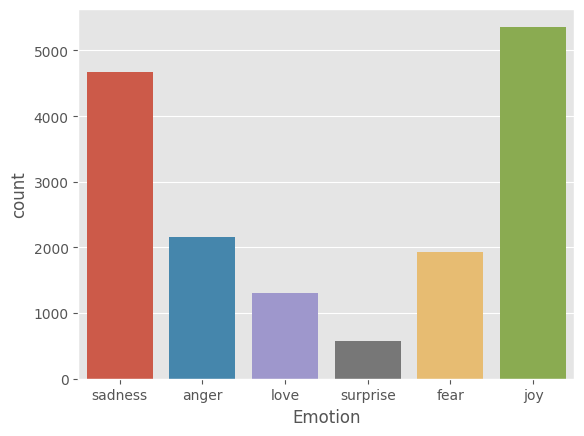

In [22]:
# EDA
sns.countplot(data=train_data,x=train_data['Emotion'], hue='Emotion', hue_order=train_data['Emotion'].unique())
plt.show()

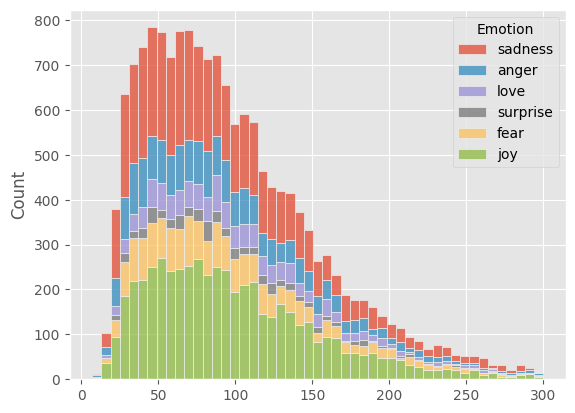

In [23]:
df2 = train_data.copy()
length_values = df2['length'].values
sns.histplot(data=df2, x=length_values, hue='Emotion', multiple='stack')
plt.show()

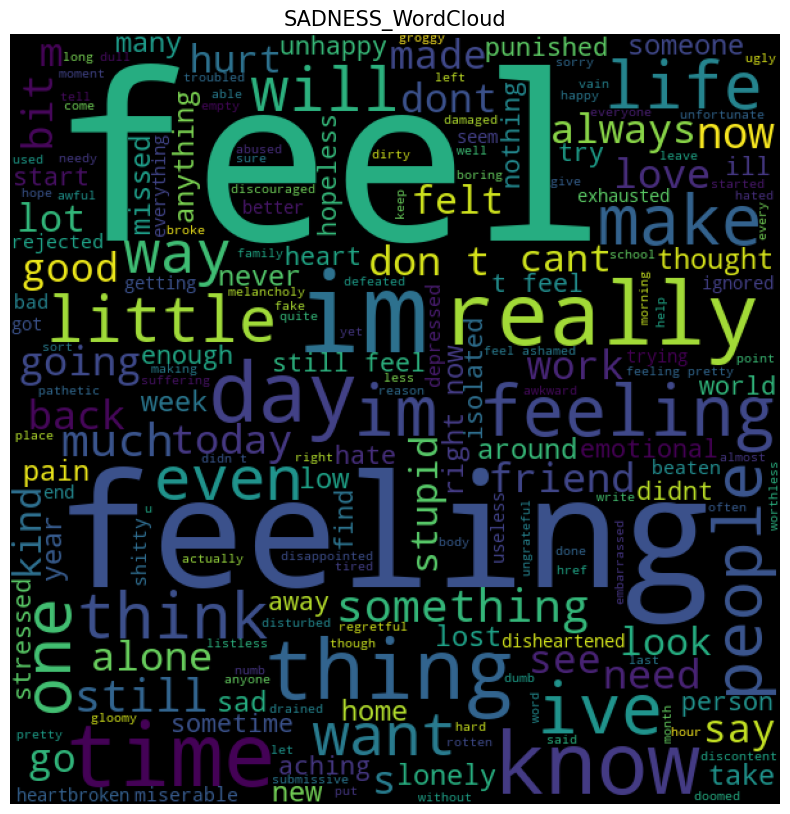

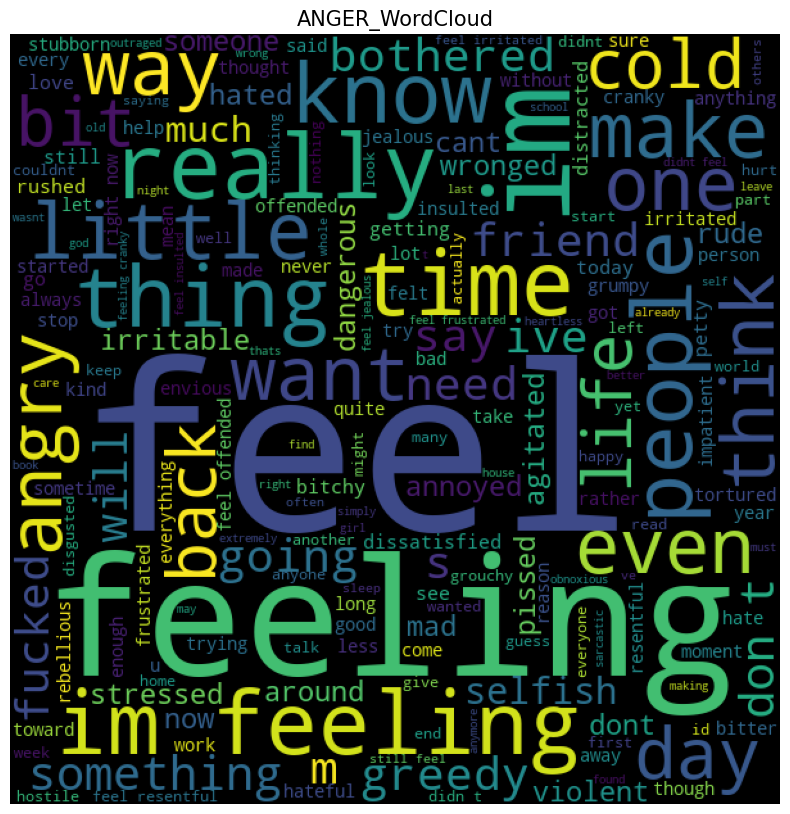

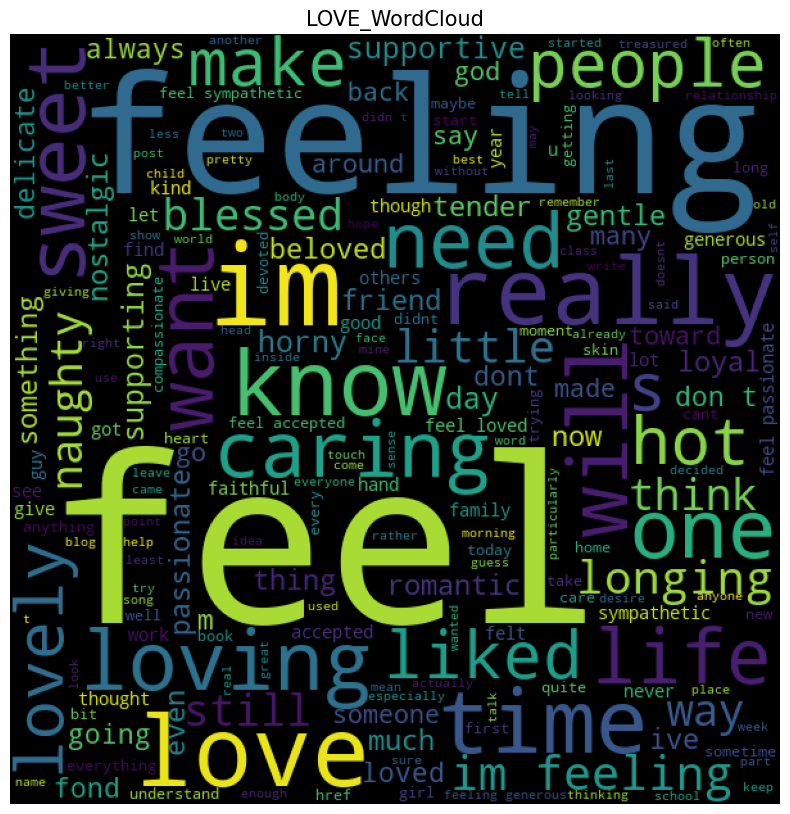

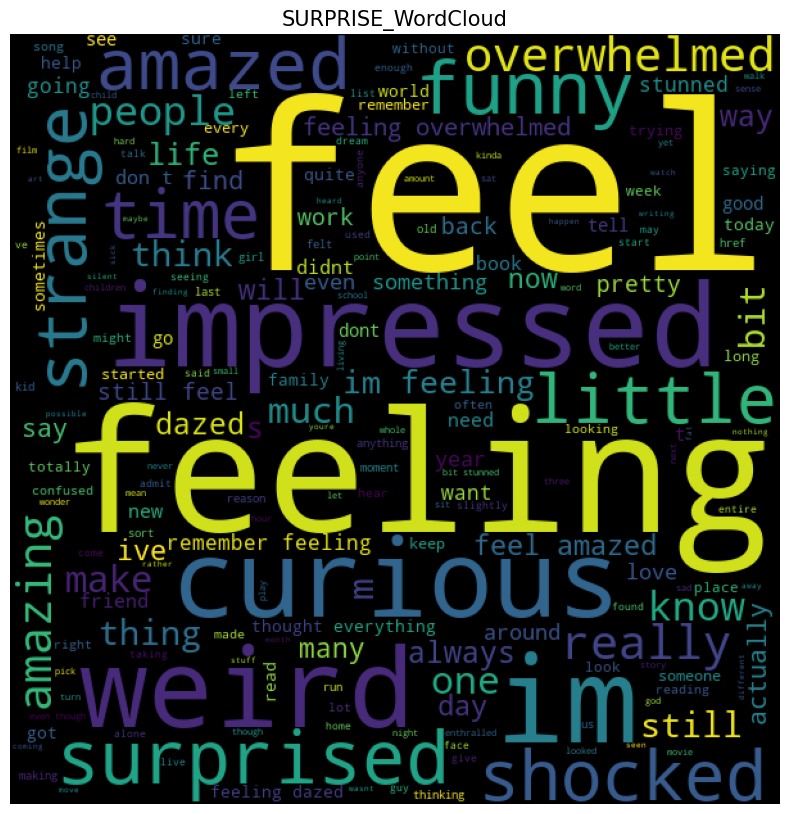

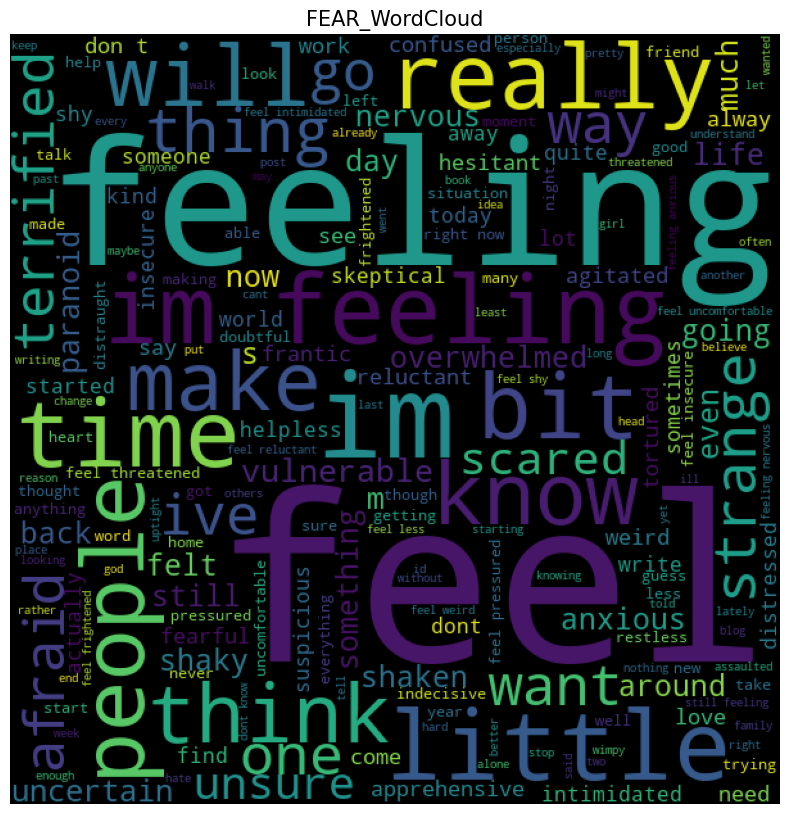

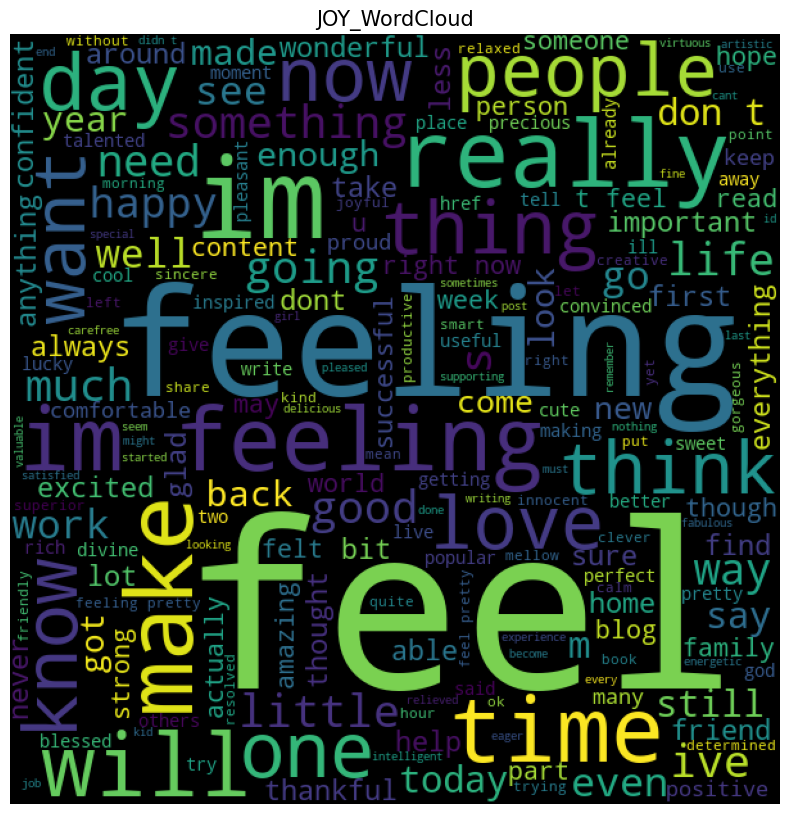

In [24]:
def words_cloud(wordcloud, emotion):
    plt.figure(figsize=(10,10))
    plt.title(emotion+ '_WordCloud', size=15)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = " ".join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion, 'Comment']])
    wordscloud = WordCloud(width=600, height=600).generate(text)
    words_cloud(wordcloud=wordscloud, emotion=emotion.upper())

In [25]:
# Data Preprocessing
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [26]:
df = train_data.copy()

In [27]:
tqdm.pandas()
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

def clean_data(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]"," ", text)
    text = text.lower()
    text = text.split()
    return " ".join([stemmer.stem(word) for word in text if word not in stopwords])

#df['cleaned_comment'] = df['Comment'].progress_apply(clean_data)
df['cleaned_comment'] = df['Comment'].progress_apply(stem_text)


[nltk_data] Downloading package stopwords to C:\Users\ict-
[nltk_data]     tyson\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
100%|██████████| 16000/16000 [00:10<00:00, 1527.27it/s]


In [28]:
df

,Comment,Emotion,length,cleaned_comment
0,i didnt feel humiliated,4,23,didnt feel humili
1,i can go from feeling so hopeless to so damned...,4,108,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,0,48,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,3,92,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,0,20,feel grouchi
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101,brief time beanbag said anna feel like beaten
15996,i am now turning and i feel pathetic that i am...,4,102,turn feel pathet still wait tabl sub teach degre
15997,i feel strong and good overall,2,30,feel strong good overal
15998,i feel like this was such a rude comment and i...,0,59,feel like rude comment im glad


In [29]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'], df['Emotion'], test_size=0.2, random_state=42)

In [30]:
# tfidfvectorizer = TfidfVectorizer()
# X_train_tfidf = tfidfvectorizer.fit_transform(X_train)
# X_test_tfidf = tfidfvectorizer.transform(X_test)
# classifier = {
#     "MultinomialNB":MultinomialNB(),
#     "LogisticRegression":LogisticRegression(),
#     "RandomForestClassifier":RandomForestClassifier(),
#     "Support Vector Machine":SVC(),
# }

# models={}
# for name, clf in tqdm(classifier.items()):
#     logger.info(f"\n{'=='*50}{name}{'=='*50}")
#     clf.fit(X_train_tfidf, y_train)
#     y_predtfidf = clf.predict(X_test_tfidf)
#     acc_score = accuracy_score(y_test, y_predtfidf)
#     logger.info(f"\n{'=='*50}{acc_score}{'=='*50}")
#     logger.info("Classification Report")
#     logger.info(classification_report(y_test, y_predtfidf))
#     models.update({
#         name:clf,
#         f"{name}_accuracy_score":acc_score
#         })

classifier = ml_classifier(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
X_train_tfidf, X_test_tfidf, vectorizer = classifier.vectorize()
model_dict = classifier.train_and_predict()

[ 2024-12-23 12:59:25,696 ] 62 ml_classifier - INFO - 
====================================================================================================MultinomialNB====================================================================================================
[ 2024-12-23 12:59:25,715 ] 67 ml_classifier - INFO - 
====================================================================================================0.655====================================================================================================
[ 2024-12-23 12:59:25,716 ] 68 ml_classifier - INFO - Classification Report
[ 2024-12-23 12:59:25,718 ] 69 ml_classifier - INFO -               precision    recall  f1-score   support

           0       0.93      0.31      0.46       427
           1       0.91      0.24      0.38       397
           2       0.58      0.98      0.73      1021
           3       1.00      0.03      0.06       296
           4       0.70      0.91      0.79       946
           5   

In [31]:
save_object(file_name="LogisticRegressionModel.pkl",object=model_dict['LogisticRegression_model'])
save_object(file_name="vectorizer.pkl",object=vectorizer)
save_object(file_name="encoder.pkl",object=lb)

[ 2024-12-23 13:00:38,383 ] 43 ml_classifier - INFO - Object saved in objects\LogisticRegressionModel.pkl
[ 2024-12-23 13:00:38,391 ] 43 ml_classifier - INFO - Object saved in objects\vectorizer.pkl
[ 2024-12-23 13:00:38,406 ] 43 ml_classifier - INFO - Object saved in objects\encoder.pkl


In [21]:
# def predict_emotion(input_text):
#     model=models['LogisticRegression']
#     cleaned_text = clean_data(input_text)
#     input_vectorizer = tfidfvectorizer.transform([cleaned_text])
#     predicted_label = model.predict(input_vectorizer)[0]
#     predicted_emotion = lb.inverse_transform([predicted_label])[0]
#     label=np.max(model.predict(input_vectorizer))

#     return predicted_emotion, label

In [22]:
# def create_sequences(df, label, vocab_size, max_len):
#     tqdm._instances.clear()
#     stemmer = PorterStemmer()
#     corpus=[]
#     for text in tqdm(df[label]):
#         text = re.sub("[^a-zA-Z]"," ", text)
#         text = text.lower()
#         text = text.split()
#         text = " ".join([stemmer.stem(word) for word in text if word not in stopwords])
#         corpus.append(text)
#     excoded_text = [one_hot(input_text=word, n=vocab_size) for word in corpus]
#     pad = pad_sequences(sequences=excoded_text, maxlen=max_len, padding="pre")
#     return pad

lstm=keras_lstm(df=df, text_label="Comment", cat_label="Emotion")
sequences = lstm.create_sequences(vocab_size=11000, max_len=300, stemmer=PorterStemmer(), stopwords=stopwords)
labels = lstm.create_categories()

100%|██████████| 16000/16000 [00:03<00:00, 4371.61it/s]


In [ ]:
# sequences = create_sequences(df=df,label="Comment", vocab_size=11000, max_len=300)
# labels = to_categorical(df['Emotion'])

In [23]:
input_size=11000
output_size=150
input_length=300
epochs=10
batch_size=32
trained_model = lstm.model(input_size=input_size, 
                           output_size=output_size, 
                           input_length=input_length, 
                           epochs=epochs, batch_size=batch_size)
keras_lstm.save_model(trained_model)

[ 2024-12-22 19:39:01,953 ] 126 ml_classifier - INFO - <<<<< LSTM Model configured >>>>>
[ 2024-12-22 19:39:01,955 ] 128 ml_classifier - INFO - <<<<< Early stopping added to callbacks >>>>>
[ 2024-12-22 19:39:01,957 ] 129 ml_classifier - INFO - <<<<< Training Initialized >>>>>


/home/tyson/Learning/SentimentAnalysis_TF/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 350s 690ms/step - accuracy: 0.3659 - loss: 1.5742
Epoch 2/10


/home/tyson/Learning/SentimentAnalysis_TF/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 257s 514ms/step - accuracy: 0.8200 - loss: 0.5762
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 230s 460ms/step - accuracy: 0.9176 - loss: 0.2419
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 231s 463ms/step - accuracy: 0.9459 - loss: 0.1573
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 232s 464ms/step - accuracy: 0.9566 - loss: 0.1234
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 229s 458ms/step - accuracy: 0.9650 - loss: 0.0971
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 232s 463ms/step - accuracy: 0.9694 - loss: 0.0858
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 230s 460ms/step - accuracy: 0.9749 - loss: 0.0717
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 231s 461ms/step - accuracy: 0.9770 - loss: 0.0603
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 236s 471ms/step - accuracy: 0.9802 - loss: 0.0524
[ 2024-12-22 20:19:59,427 ] 131 ml_classifier - INFO - <<<<< Training Completed! >>>>>
[ 2024-12-22 20:19:59,429 ] 83 absl - WARNING - You are saving your model as an HDF5 file via `model.save()` or `

In [9]:
# #LSTM model
# model = Sequential()
# model.add(Embedding(input_dim=input_size, output_dim=output_size, input_length=input_length))
# model.add(Dropout(0.2))
# model.add(LSTM(128))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='sigmoid'))
# model.add(Dropout(0.2))
# model.add(Dense(6, activation='softmax'))
# model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
# model.fit(sequences, labels, epochs=5, batch_size=32, verbose=1, callbacks=[early_stopping])

#K.saving.save_model(trained_model, filepath='artifacts/objects/trained_model.keras')
#K.saving.load_model

input_size=11000
output_size=150
input_length=300
epochs=10
batch_size=32
stopwords = set(stopwords.words('english'))
encoder = load_object(os.path.join("objects","encoder.pkl"))
vectorizer = load_object(os.path.join("objects","vectorizer.pkl"))
trained_model = K.saving.load_model('objects/trained_model.keras')

c:\Users\ict-tyson\OneDrive - Association of Accounting Technicians\Desktop\Projects\sentimentanalysis_tf\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
sentence = "The weather is looking great, i might go for a run"
keras_lstm.predict_emotion(model=trained_model,sentence=sentence, stemmer=PorterStemmer(), stopwords=stopwords, vocab_size=input_size, max_len=input_length, encoder=encoder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
The sentiment is 4, with probability of 49.576619267463684


(4, 49.576619267463684)